In [268]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = "repayment.csv"
repayment_df = pd.read_csv(file_path)


In [269]:
repayment_df['Model Version'] = np.where(repayment_df['Model Version'] == 'Model_A', 'Model A', 'Model B')

In [270]:
repayment_df.info(), repayment_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Origination Month          276 non-null    object
 1   Model Version              276 non-null    object
 2   Payment Number             276 non-null    int64 
 3   Expected Loan Repayment    276 non-null    object
 4   Forecasted Loan Repayment  276 non-null    object
 5   Actual Loan Repayment      276 non-null    object
dtypes: int64(1), object(5)
memory usage: 13.1+ KB


(None,
   Origination Month Model Version  Payment Number Expected Loan Repayment  \
 0          1/1/2023       Model A               1             $106,000.00   
 1          1/1/2023       Model A               2             $106,000.00   
 2          1/1/2023       Model A               3             $106,000.00   
 3          1/1/2023       Model A               4             $106,000.00   
 4          1/1/2023       Model A               5             $106,000.00   
 
   Forecasted Loan Repayment Actual Loan Repayment  
 0               $105,788.00           $105,788.00  
 1               $105,576.42           $105,945.94  
 2               $105,365.27           $105,312.59  
 3               $105,154.54           $105,007.32  
 4               $104,944.23           $104,660.88  )

## Data Cleaning

In [271]:
# Convert monetary columns to numeric values by removing '$' and ','
monetary_columns = ["Expected Loan Repayment", "Forecasted Loan Repayment", "Actual Loan Repayment"]
for col in monetary_columns:
    repayment_df[col] = repayment_df[col].replace({'\$': '', ',': ''}, regex=True).astype(float)

In [272]:
repayment_df['mape'] = abs(repayment_df['Actual Loan Repayment'] - repayment_df['Forecasted Loan Repayment'])/repayment_df['Actual Loan Repayment'] 

In [273]:
def compute_metrics(actual, forecast):
    mae = np.mean(np.abs(actual - forecast))
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    rmse = np.sqrt(np.mean((actual - forecast) ** 2))
    smape = np.mean(2 * np.abs(actual - forecast) / (np.abs(actual) + np.abs(forecast))) * 100
    return {"MAE": mae, "MAPE": mape, "RMSE": rmse, "SMAPE": smape}

# Group by Model Version and compute metrics
model_metrics = repayment_df.groupby("Model Version").apply(
    lambda x: compute_metrics(x["Actual Loan Repayment"], x["Forecasted Loan Repayment"])
).apply(pd.Series)

# Compute accuracy metrics based on Payment Number
payment_metrics = repayment_df.groupby(["Model Version", "Payment Number"]).apply(
    lambda x: compute_metrics(x["Actual Loan Repayment"], x["Forecasted Loan Repayment"])
).apply(pd.Series)



/tmp/ipykernel_2799/2871988893.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  model_metrics = repayment_df.groupby("Model Version").apply(
/tmp/ipykernel_2799/2871988893.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  payment_metrics = repayment_df.groupby(["Model Version", "Payment Number"]).apply(


In [274]:
payment_mape = repayment_df.groupby(["Model Version", "Payment Number"]).apply(
    lambda x: np.mean(np.abs((x["Actual Loan Repayment"] - x["Forecasted Loan Repayment"]) / x["Actual Loan Repayment"])) * 100
).reset_index(name="MAPE")
payment_mape

/tmp/ipykernel_2799/141816248.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  payment_mape = repayment_df.groupby(["Model Version", "Payment Number"]).apply(


,Model Version,Payment Number,MAPE
0,Model A,1,0.208714
1,Model A,2,0.384360
2,Model A,3,0.510015
3,Model A,4,0.619309
4,Model A,5,0.739106
5,Model A,6,1.004972
6,Model A,7,0.995266
7,Model A,8,0.922410
8,Model A,9,1.002641
9,Model A,10,1.109037


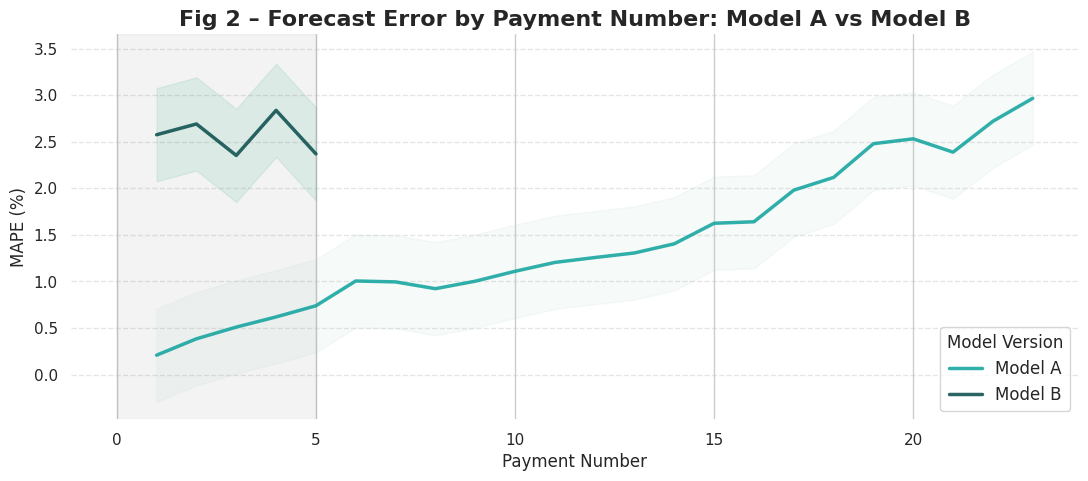

<Figure size 640x480 with 0 Axes>

In [363]:
# Set seaborn style and font to something close to Montserrat
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "DejaVu Sans"  # Closest available to Montserrat in Matplotlib
dark_teal_variants = ['#0da29c', '#064a48']
palette_map = {model: dark_teal_variants[i] for i, model in enumerate(repayment_df["Model Version"].unique())}

# Plot MAPE by Payment Number with shaded first 5 payments (without legend entry for shading)
fig, ax = plt.subplots(figsize=(13, 5))

# Shade the first 5 payments to highlight the key comparison area (without adding to legend)
ax.axvspan(0, 5, color="gray", alpha=0.09)

# Plot the MAPE lines for Model A and Model B
for i, model in enumerate(repayment_df["Model Version"].unique()):
    model_data = payment_mape[payment_mape["Model Version"] == model]
    sns.lineplot(
        data=model_data,
        x="Payment Number", y="MAPE", 
        label=model, color=palette_map[model], linewidth=2.5, alpha=0.85
    )

    # Create a soft blur effect using fill between
    x_vals = model_data["Payment Number"].to_numpy()
    y_vals = model_data["MAPE"].to_numpy()
    ax.fill_between(x_vals, y_vals - 0.5, y_vals + 0.5, color=gradient_teal[i], alpha=0.1)  # Soft glow effect

ax.set_title("Fig 2 – Forecast Error by Payment Number: Model A vs Model B", fontsize=16, fontweight="bold")
ax.set_xlabel("Payment Number", fontsize=12)
ax.set_ylabel("MAPE (%)", fontsize=12)

# Set x-axis ticks to display every 5 payments (e.g., 0, 5, 10, 15, etc.)
max_payment = int(payment_mape["Payment Number"].max())
ax.set_xticks(range(0, max_payment + 1, 5))

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.legend(title="Model Version", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)  # Softer grid effect
sns.despine(left=True, bottom=True)
plt.show()
plt.savefig("plot.png", dpi=300, bbox_inches="tight", transparent=True)  # Best for PowerPoint


## Adding repayment data column

In [276]:
# Convert 'Origination Month' to a datetime format
repayment_df["Origination Month"] = pd.to_datetime(repayment_df["Origination Month"])

# Create 'Payment Date' field by adding 'Payment Number' (as months) to 'Origination Month'
repayment_df["Payment Date"] = repayment_df.apply(
    lambda x: x["Origination Month"] + pd.DateOffset(months=int(x["Payment Number"])), axis=1
)

In [277]:
# Compare Model A and Model B by accuracy based on Payment Date
payment_date_mape = repayment_df.groupby(["Model Version", "Payment Date"]).apply(
    lambda x: np.mean(np.abs((x["Actual Loan Repayment"] - x["Forecasted Loan Repayment"]) / x["Actual Loan Repayment"])) * 100
).reset_index(name="MAPE")

/tmp/ipykernel_2799/784973471.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  payment_date_mape = repayment_df.groupby(["Model Version", "Payment Date"]).apply(


In [279]:
payment_date_mape['Model Version'] = np.where(payment_date_mape['Model Version'] == 'Model_A', 'Model A', 'Model B')

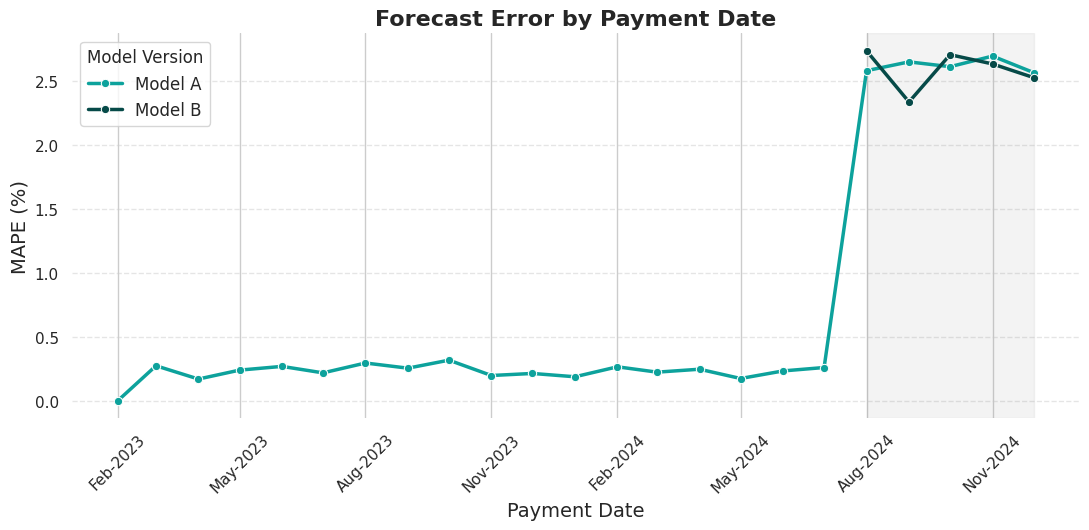

In [157]:
legend_labels = {"Model_A": "Model A", "Model_B": "Model B"}
dark_teal_variants = ['#0da29c', '#064a48']  # Dark teal for Model A, Even darker teal for Model B

# Ensure 'Payment Date' is in datetime format
payment_date_mape["Payment Date"] = pd.to_datetime(payment_date_mape["Payment Date"], format="%b-%Y")

# Identify the shading start date (August 2024)
shade_start_date = pd.to_datetime("2024-08-01")

# Set seaborn style for consistency
sns.set_style("whitegrid")

# Plot MAPE by Payment Date for Model A and Model B using very light teal colors
fig, ax = plt.subplots(figsize=(13, 5))

sns.lineplot(
    data=payment_date_mape, 
    x="Payment Date", 
    y="MAPE", 
    hue="Model Version", 
    marker="o", 
    linewidth=2.5,
    palette=dark_teal_variants  # Using very light teal colors
)

# Shade the period from August 2024 onwards using proper datetime values
ax.axvspan(shade_start_date, max(payment_date_mape["Payment Date"]), color="gray", alpha=0.09)

# Formatting
ax.set_title("Forecast Error by Payment Date", fontsize=16, fontweight="bold")
ax.set_xlabel("Payment Date", fontsize=14)
ax.set_ylabel("MAPE (%)", fontsize=14)

# Customize x-axis labels to show only every 3rd month
unique_dates = payment_date_mape["Payment Date"].sort_values().unique()
selected_dates = unique_dates[::3]  # Show every 3rd month

ax.set_xticks(selected_dates)
ax.set_xticklabels([date.strftime("%b-%Y") for date in selected_dates], rotation=45, fontsize=11)

plt.yticks(fontsize=11)
plt.legend(title="Model Version", fontsize=12)  # Custom legend labels
plt.grid(axis="y", linestyle="--", alpha=0.5)
sns.despine(left=True, bottom=True)

# Show plot
plt.show()



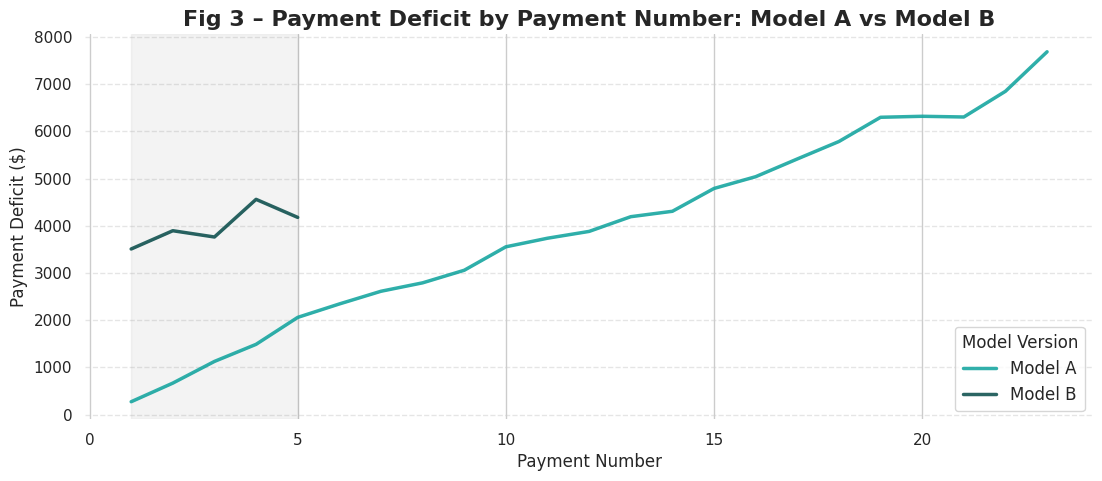

In [361]:
# Convert relevant columns to numeric
repayment_df["Actual Loan Repayment"] = pd.to_numeric(repayment_df["Actual Loan Repayment"], errors="coerce")
repayment_df["Expected Loan Repayment"] = pd.to_numeric(repayment_df["Expected Loan Repayment"], errors="coerce")

# Calculate Repayment Shortfall
repayment_df["Repayment Shortfall"] = abs(repayment_df["Actual Loan Repayment"] - repayment_df["Expected Loan Repayment"])

# Group repayment shortfall by Model Version and Payment Number
shortfall_by_payment_number = repayment_df.groupby(["Model Version", "Payment Number"])["Repayment Shortfall"].mean().reset_index()

# Set seaborn style and font to something close to Montserrat
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "DejaVu Sans"  # Closest available to Montserrat in Matplotlib

# Define color palette
dark_teal_variants = ['#0da29c', '#064a48']
palette_map = {model: dark_teal_variants[i] for i, model in enumerate(shortfall_by_payment_number["Model Version"].unique())}

# Identify the common payment number range between Model A and B
common_payments = set(shortfall_by_payment_number[shortfall_by_payment_number["Model Version"] == "Model A"]["Payment Number"]).intersection(
    set(shortfall_by_payment_number[shortfall_by_payment_number["Model Version"] == "Model B"]["Payment Number"])
)

# Define start and end of common period
if common_payments:
    common_start, common_end = min(common_payments), max(common_payments)

# Create the plot
fig, ax = plt.subplots(figsize=(13, 5))

# Shade the common period to highlight the overlapping timeframe
if common_payments:
    ax.axvspan(common_start, common_end, color="gray", alpha=0.09)

# Plot repayment shortfall for Model A and Model B
for i, model in enumerate(shortfall_by_payment_number["Model Version"].unique()):
    model_data = shortfall_by_payment_number[shortfall_by_payment_number["Model Version"] == model]
    sns.lineplot(
        data=model_data,
        x="Payment Number", y="Repayment Shortfall", 
        label=model, color=palette_map[model], linewidth=2.5, alpha=0.85
    )

    # Create a soft blur effect using fill between
    x_vals = model_data["Payment Number"].to_numpy()
    y_vals = model_data["Repayment Shortfall"].to_numpy()
    ax.fill_between(x_vals, y_vals - 0.5, y_vals + 0.5, color=dark_teal_variants[i], alpha=0.1)  # Soft glow effect

# Formatting
ax.set_title("Fig 3 – Payment Deficit by Payment Number: Model A vs Model B", fontsize=16, fontweight="bold")
ax.set_xlabel("Payment Number", fontsize=12)
ax.set_ylabel("Payment Deficit ($)", fontsize=12)

# Set x-axis ticks to display every 5 payments (e.g., 0, 5, 10, 15, etc.)
max_payment = int(shortfall_by_payment_number["Payment Number"].max())
ax.set_xticks(range(0, max_payment + 1, 5))

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.legend(title="Model Version", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)  # Softer grid effect
sns.despine(left=True, bottom=True)

# Show and save plot
plt.show()


In [184]:
last_six_month_mape = repayment_df[repayment_df['Payment Date'] >= '2024-08-01'].groupby(['Model Version']).agg(avg_mape = ('mape','mean'))

In [203]:
payment_date_mape[payment_date_mape["Payment Date"] >= six_months_ago].groupby("Model Version")["MAPE"].mean()

Model Version
Model A    2.623475
Model B    2.590461
Name: MAPE, dtype: float64

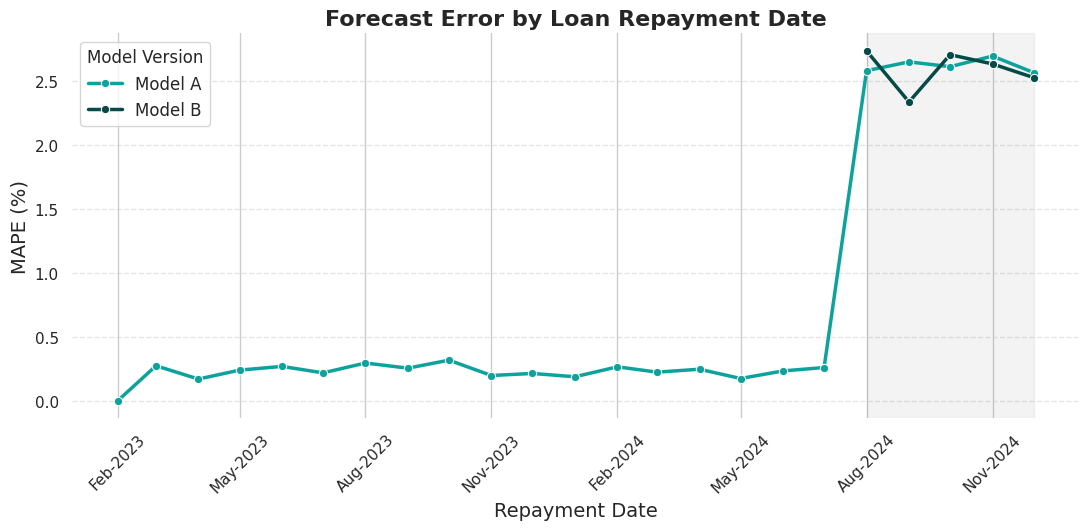

In [263]:
latest_date = payment_date_mape["Payment Date"].max()
six_months_ago = latest_date - pd.DateOffset(months=4)
avg_mape_last_6_months = payment_date_mape[payment_date_mape["Payment Date"] >= six_months_ago].groupby("Model Version")["MAPE"].mean()
# Convert unique dates to pandas Timestamps for proper formatting
selected_dates = [pd.Timestamp(date) for date in selected_dates]

# Set seaborn style for consistency
sns.set_style("whitegrid")

# Plot MAPE by Payment Date for Model A and Model B using very light teal colors
fig, ax = plt.subplots(figsize=(13, 5))

sns.lineplot(
    data=payment_date_mape, 
    x="Payment Date", 
    y="MAPE", 
    hue="Model Version", 
    marker="o", 
    linewidth=2.5,
    palette=dark_teal_variants  # Using very light teal colors
)

# Shade the period from August 2024 onwards using proper datetime values
ax.axvspan(shade_start_date, latest_date, color="gray", alpha=0.09)



# Formatting
ax.set_title("Forecast Error by Loan Repayment Date", fontsize=16, fontweight="bold")
ax.set_xlabel("Repayment Date", fontsize=14)
ax.set_ylabel("MAPE (%)", fontsize=14)

# Set x-axis ticks and labels
ax.set_xticks(selected_dates)
ax.set_xticklabels([date.strftime("%b-%Y") for date in selected_dates], rotation=45, fontsize=11)

plt.yticks(fontsize=11)
plt.legend(title="Model Version", fontsize=12, loc="upper left")  # Custom legend labels, moved to top left
plt.grid(axis="y", linestyle="--", alpha=0.5)
sns.despine(left=True, bottom=True)

# Show plot
plt.show()


In [358]:
modelA_mape_before_aug= repayment_df[(repayment_df['Payment Date'] <= '2024-08-01') &
                                      (repayment_df['Model Version'] == 'Model A')].groupby(['Model Version']).agg(mape_before = ('mape','mean'))
modelA_mape_before_aug['mape_before']= modelA_mape_before_aug['mape_before']*100

In [359]:
modelA_mape_after_aug= repayment_df[(repayment_df['Payment Date'] >= '2024-08-01') & 
                                     (repayment_df['Model Version'] == 'Model A')].groupby(['Model Version']).agg(mape_after = ('mape','mean'))
modelA_mape_after_aug['mape_after'] = modelA_mape_after_aug['mape_after']*100

In [360]:
modelA_mape_before_after_merged = modelA_mape_before_aug.merge(modelA_mape_after_aug, left_index = True, right_index = True)
modelA_mape_before_after_merged['increase'] = round(modelA_mape_before_after_merged['mape_after']/modelA_mape_before_after_merged['mape_before'],2)
modelA_mape_before_after_merged['mape_before'] = round(modelA_mape_before_after_merged['mape_before'], 2)
modelA_mape_before_after_merged['mape_after'] = round(modelA_mape_before_after_merged['mape_after'], 2)

modelA_mape_before_after_merged.style.set_properties(**{
    'text-align': 'center'
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'center')]
}])

modelA_mape_before_after_merged

,mape_before,mape_after,increase
Model Version,,,
Model A,0.46,2.62,5.73


In [191]:
last_six_month_mape = repayment_df[repayment_df['Payment Date'] >= '2024-08-01'].groupby(['Model Version','Payment Date']).agg(avg_mape = ('mape','mean'))
last_six_month_mape = last_six_month_mape.reset_index()

In [193]:
last_six_month_mape['total_avgmape'] = 

,Model Version,Payment Date,avg_mape
0,Model A,2024-08-01,0.025836
1,Model A,2024-09-01,0.026525
2,Model A,2024-10-01,0.026148
3,Model A,2024-11-01,0.026977
4,Model A,2024-12-01,0.025689
5,Model B,2024-08-01,0.027388
6,Model B,2024-09-01,0.023388
7,Model B,2024-10-01,0.027087
8,Model B,2024-11-01,0.026364
9,Model B,2024-12-01,0.025298


In [294]:
aug_repayments = repayment_df[repayment_df['Payment Date'] >= '2024-08-01']

In [306]:
# Ensure relevant columns are in datetime format
aug_repayments["Origination Month"] = pd.to_datetime(aug_repayments["Origination Month"]).dt.date
aug_repayments["Payment Date"] = pd.to_datetime(aug_repayments["Payment Date"]).dt.date

pivot_df = aug_repayments.pivot_table(
    index="Payment Date",
    columns="Model Version",
    values="Repayment Shortfall",
    aggfunc="mean"
).reset_index()

# Add a column to show the difference between Model A and Model B
pivot_df["Difference"] = pivot_df["Model A"] - pivot_df["Model B"]
pivot_df['Model A'] = pivot_df['Model A'].astype(int)
pivot_df['Model B'] = pivot_df['Model B'].astype(int)
pivot_df["Difference"] = pivot_df["Difference"].astype(int)

# Convert values to integers and format them as currency ($)
for col in ["Model A", "Model B", "Difference"]:
    if col in pivot_df.columns:  # Ensure column exists
        pivot_df[col] = pivot_df[col].fillna(0).astype(int).apply(lambda x: f"${x:,}")

        
# Format table for display with text centered
styled_pivot_df = pivot_df.style.set_properties(**{
    'text-align': 'center'
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'center')]
}])

styled_pivot_df

/tmp/ipykernel_2799/576114243.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aug_repayments["Origination Month"] = pd.to_datetime(aug_repayments["Origination Month"]).dt.date
/tmp/ipykernel_2799/576114243.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aug_repayments["Payment Date"] = pd.to_datetime(aug_repayments["Payment Date"]).dt.date


Model Version,Payment Date,Model A,Model B,Difference
0,2024-08-01,"$5,325","$3,634","$1,691"
1,2024-09-01,"$5,624","$3,324","$2,299"
2,2024-10-01,"$5,796","$3,950","$1,845"
3,2024-11-01,"$6,128","$3,953","$2,175"
4,2024-12-01,"$6,229","$3,951","$2,277"


In [291]:
styled_pivot_df

Model Version,Payment Date,Model A,Model B,Difference (Model A - Model B)
0,2024-08-01 00:00:00,5326.000000,3635.000000,1691.000000
1,2024-09-01 00:00:00,5624.000000,3324.000000,2300.000000
2,2024-10-01 00:00:00,5796.000000,3951.000000,1845.000000
3,2024-11-01 00:00:00,6129.000000,3953.000000,2175.000000
4,2024-12-01 00:00:00,6229.000000,3952.000000,2277.000000
